In [1]:
import qiskit
from qoop.core import state, metric, ansatz
from qoop.compilation.qsp import QuantumStatePreparation
from qoop.evolution.environment_synthesis import MetadataSynthesis
from qoop.evolution.environment import EEnvironment
from qoop.evolution import crossover, divider, normalizer, generator
from qiskit.quantum_info import random_unitary
from qiskit.circuit.library import UnitaryGate
import pennylane as qml
from sync import cost as cost_func
from sync import circuit, constant
import pennylane.numpy as nps
import pennylane as qml
%load_ext autoreload
%autoreload 2
def fitness_synthesis(qc_qiskit: qiskit.QuantumCircuit):
    dev = qml.device("default.qubit")
    qfunc = qml.from_qiskit(qc_qiskit, measurements=qml.expval(qml.Z(0)))
    qc = qml.QNode(qfunc, dev)

    thetas = nps.random.uniform(0, 2*nps.pi, len(qc_qiskit.parameters))
    def cost(thetas):
        matrix = qml.matrix(qc, wire_order=list(range(qc_qiskit.num_qubits)))(thetas)
        return cost_func.c_hst(matrix, target)

    steps = 1000
    costs = []
    opt = qml.AdamOptimizer(stepsize = 0.01)
    for n in range(steps):
        thetas, prev_cost = opt.step_and_cost(cost, thetas)
        if prev_cost < constant.error:
            print("Achieved error threshold at step", n)
            break
        costs.append(prev_cost)
    return costs[-1]

env_metadata = MetadataSynthesis(
        num_qubits = 3, # As its name
        num_cnot = 10, # Number of CNOT gate you want
        depth = 10, # Ansatz depth you want
        num_circuit = 8, # Number of ansatz per generation
        num_generation = 10, # Number of generation/iteration for GA 
        prob_mutate = 0.01 # Mutation probability, usually as small as 0.01 (1%)
)

target = UnitaryGate(random_unitary(2**env_metadata.num_qubits))
env = EEnvironment(
    metadata = env_metadata,
    fitness_func = fitness_synthesis,
    generator_func = generator.by_num_cnot,
    crossover_func = crossover.onepoint(
        divider.by_depth(int(env_metadata.depth/2)), 
        normalizer.by_depth(env_metadata.depth))
).evol()

Initialize list of circuit ...
Start evol progress ...
Running at generation 1


KeyboardInterrupt: 

In [ ]:

num_qubits = 3
thetas = qiskit.circuit.ParameterVector('θ', 12)
qc_qiskit = qiskit.QuantumCircuit(num_qubits)
qc_qiskit.cx(0, 1)
qc_qiskit.cx(1, 2)
qc_qiskit.cx(0, 1)
for i in range(0, 4):
    qc_qiskit.barrier()
    qc_qiskit.rx(thetas[i], 0)
    qc_qiskit.ry(thetas[i + 4], 1)
    qc_qiskit.rz(thetas[i + 8], 2)
    
def fitness_synthesis(qc: qiskit.QuantumCircuit):
    dev = qml.device("default.qubit")
    qfunc = qml.from_qiskit(qc_qiskit, measurements=qml.expval(qml.Z(0)))
    qc = qml.QNode(qfunc, dev)

    thetas = nps.random.uniform(0, 2*nps.pi, len(qc_qiskit.parameters))
    def cost(thetas):
        matrix = qml.matrix(qc, wire_order=list(range(num_qubits)))(thetas)
        return cost_func.c_hst(matrix, target)

    steps = 100
    costs = []
    opt = qml.AdamOptimizer(stepsize = 0.01)
    for n in range(steps):
        thetas, prev_cost = opt.step_and_cost(cost, thetas)
        if prev_cost < constant.error:
            print("Achieved error threshold at step", n)
            break
        costs.append(prev_cost)
    return costs[-1]

# grad_fn = qml.grad(func = cost)
# for i in range(steps):
# 	gradient = grad_fn(thetas)
# 	thetas = thetas - 0.1 * gradient
# 	costs.append(cost(thetas))

In [16]:
drawer = qml.draw(qc)
print(drawer(thetas))

0: ─╭●────╭●─╭||──RX(2.86)─╭||──RX(3.15)─╭||──RX(5.24)──╭||──RX(4.07)─┤  <Z>
1: ─╰X─╭●─╰X─├||──RY(4.66)─├||──RY(5.51)─├||──RY(1.64)──├||──RY(1.71)─┤     
2: ────╰X────╰||──RZ(4.01)─╰||──RZ(2.09)─╰||──RZ(-0.39)─╰||──RZ(3.94)─┤     


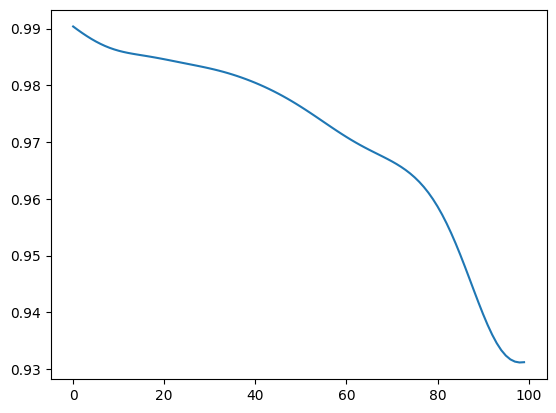

In [17]:
import matplotlib.pyplot as plt
plt.plot(costs)